In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib
import optuna

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif
from sklearn.model_selection import TimeSeriesSplit
from sklearn.calibration import calibration_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, roc_auc_score, log_loss, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

c:\Users\matcg\Anaconda3\envs\brasileirao_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn import set_config
set_config(transform_output = 'pandas') # Retorna sempre um dataframe após transformação

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
data_full = pd.read_csv('data/data_full.csv')

df_train['data'] = pd.to_datetime(df_train['data'], format='%Y-%m-%d')
df_test['data'] = pd.to_datetime(df_test['data'], format='%Y-%m-%d')
data_full['data'] = pd.to_datetime(data_full['data'], format='%Y-%m-%d')

In [4]:
df_odds = pd.read_csv('data/historico_odds.csv', encoding='latin-1', sep=';')

for col in ['PH', 'PD', 'PA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA']:
    df_odds[col] = df_odds[col].str.replace(',','.').astype(float) # Substitui , por .

df_odds['Date'] = pd.to_datetime(df_odds['Date'], format='%d/%m/%Y')

In [5]:
# Agrega a informação de Odds
df_train = pd.merge(df_train,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

df_test = pd.merge(df_test,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

data_full = pd.merge(data_full,
                   df_odds[['Season','Home','Away', 'AvgH', 'AvgD', 'AvgA']],
                   how='left',
                   left_on=['ano_campeonato', 'time_man','time_vis'],
                   right_on=['Season','Home','Away']).drop(columns=['Season','Home','Away'])

In [6]:
df_train.shape, df_test.shape

((1081, 163), (450, 163))

### Seleção de Features e Pré-processamento dos dados

Tanto o pre-processamento quanto a seleção de feature será feito sobre o conjunto de treinamento.

In [8]:
dropar = ['data',  'estadio', 'arbitro', 'time_man', 'tecnico_man', 'time_vis','tecnico_vis', 
          'vitoria_man', 'vitoria','ano_campeonato','rodada', 'AvgH', 'AvgD', 'AvgA']

X_train = df_train.drop(dropar ,axis=1)
y_train = df_train['vitoria']

X_test = df_test.drop(dropar ,axis=1)
y_test = df_test['vitoria']


In [9]:
# Apesar das variaveis de 'colocacao' serem categoricas ordinais, vamos normalizá-las como numericas.
cat_ord = ['tecnico_man_enc', 'tecnico_vis_enc', 'time_man_enc', 'time_vis_enc'] # Categoricas Ordinais por Encoding
num_features = [col for col in X_train.columns.to_list() if col not in cat_ord] 


# Como as variaveis de valor de equipe estão zerada em 2023, nao vamos utiliza-las.
num_features.remove('valor_equipe_titular_man')
num_features.remove('diff_valor_equipe_adv_man')
num_features.remove('valor_equipe_titular_vis')

In [10]:
def cria_pipeline(num_varlist, cat_ord_varlist):
    
    num_pipeline = None
    cat_ord_pipeline = None

    if len(num_varlist) > 0:
        num_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), 
            ('scaler', MinMaxScaler())
        ])
    if len(cat_ord_varlist) > 0:
        cat_ord_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')) # Para variaveis de encoding, imputa mising com a media            
        ])

    if num_pipeline is not None or cat_ord_pipeline is not None:
        transformers = []
        if num_pipeline is not None:
            transformers.append(('num', num_pipeline, num_varlist))
            # transformers.append((num_pipeline, num_varlist))
        if cat_ord_pipeline is not None:
            transformers.append(('cat_ord', cat_ord_pipeline, cat_ord_varlist))
            # transformers.append((cat_ord_pipeline, cat_ord_varlist))

        preprocessor = ColumnTransformer(transformers=transformers,
                                         verbose_feature_names_out=False) # Nao adiciona prefixo

        return preprocessor
    else:
        return None

In [11]:
preprocessor_1 = cria_pipeline(num_features, cat_ord)
preprocessor_1.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['publico', 'publico_max', 'colocacao_man',
                                  'idade_media_titular_man',
                                  'flag_jogo_casa_man',
                                  'diff_idade_media_adv_man',
                                  'diff_colocacao_adv_man', 'med_publico_3_man',
                                  'med_publico_6_man', 'med_gols_com_3_man',
                                  'med_gols_com_6_man',...
                                  'med_faltas_sof_6_man',
                                  'med_perc_faltas_sof_3_man',
                                  'med_perc_faltas_sof_6_man',
                                  'med_chutes_com_3_man',
                                  'med_chutes_com_6_man',
                                  'med_perc_chutes_com_3_man',
                                  'med_perc_chutes_com_6_man',
                                  'med_chutes_sof_3_man', ...]),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['tecnico_man_enc', 'tecnico_vis_enc',
                                  'time_man_enc', 'time_vis_enc'])],
                  verbose_feature_names_out=False)

In [12]:
X_sel_train = preprocessor_1.transform(X_train)
X_sel_test = preprocessor_1.transform(X_test)

In [13]:
def remove_multicolinearidade(df_X, y, nome_var_resp, limiar=0.8):
    # Calcula a matriz de correlação entre as variáveis independentes
    df = df_X.copy()
    df[nome_var_resp] = y

    matriz_correlacao = df.drop(columns=[nome_var_resp]).corr()

    # Encontrar pares de variáveis altamente correlacionadas
    pares_correlacionados = []
    for i in range(len(matriz_correlacao.columns)):
        for j in range(i):
            if abs(matriz_correlacao.iloc[i, j]) > limiar:
                pares_correlacionados.append((matriz_correlacao.columns[i], matriz_correlacao.columns[j]))

    # Manter apenas a variável com maior correlação com a variável resposta para cada par
    dropar = []
    for var1, var2 in pares_correlacionados:
        corr_com_var_resp1 = df[var1].corr(df[nome_var_resp])
        corr_com_var_resp2 = df[var2].corr(df[nome_var_resp])

        if abs(corr_com_var_resp1) > abs(corr_com_var_resp2):
            dropar.append(var2)
        else:
            dropar.append(var1)

    # Remove as variáveis multicolineares do DataFrame
    df_filtrado = df.drop(columns=dropar)

    return df_filtrado.drop(columns=[nome_var_resp])

In [14]:
X_sel_train.drop(['tecnico_man_enc', 'tecnico_vis_enc', 'time_man_enc', 'time_vis_enc'], axis=1, inplace=True)

In [15]:
df_filter = remove_multicolinearidade(X_sel_train, y_train,'vitoria')

#### Estatística Univariada - ANOVA

In [16]:
f_values, p_values = f_classif(df_filter, y_train)
df_anova = pd.DataFrame({'VAR': df_filter.columns,
                         'F-Score': f_values,
                         'P-Valor': p_values})

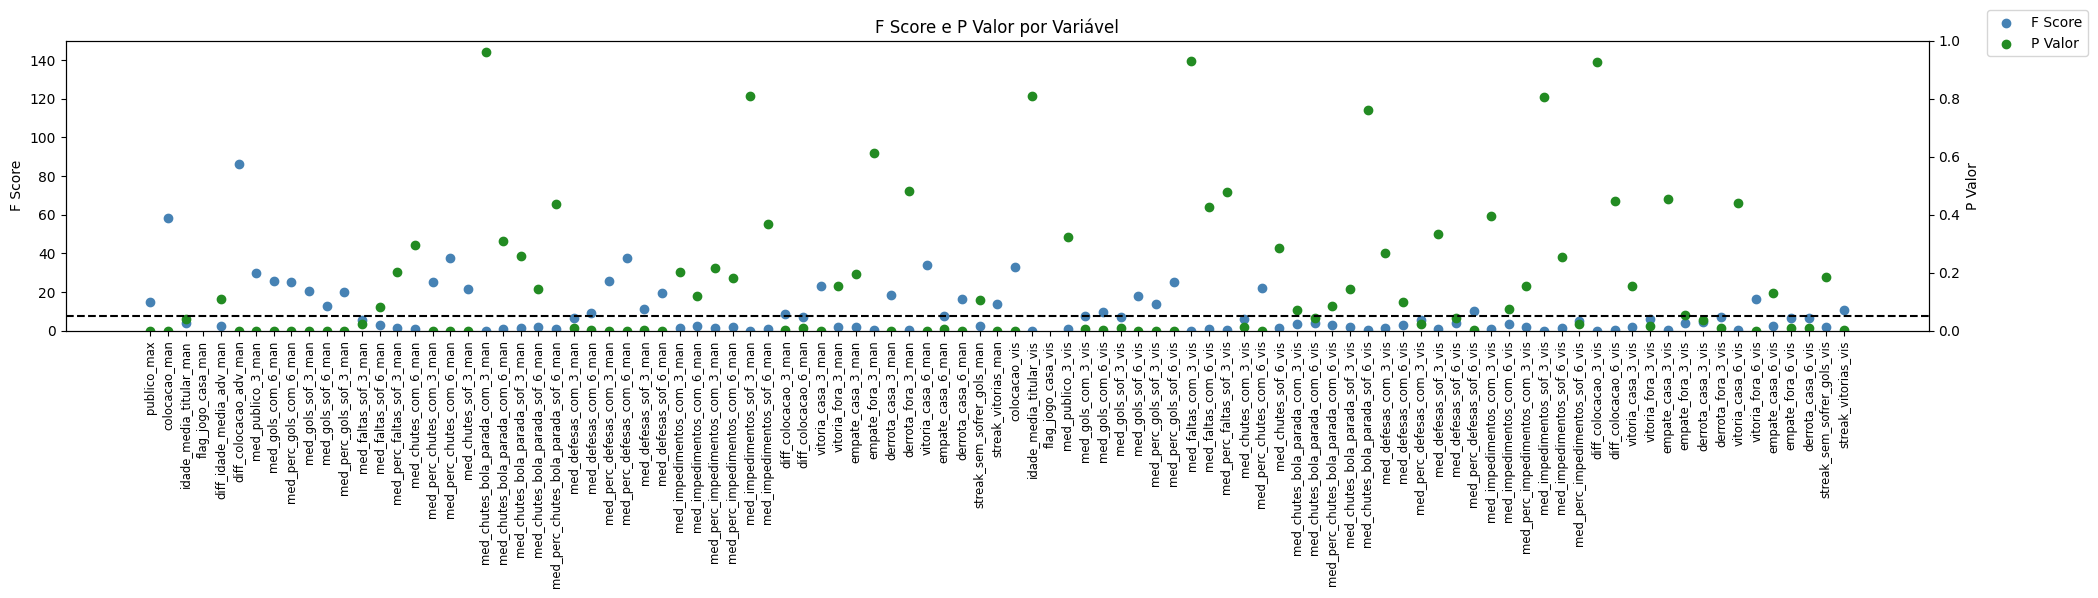

---- Variáveis em Ordem Descrescente de Força ----
diff_colocacao_adv_man
colocacao_man
med_perc_chutes_com_6_man
med_perc_defesas_com_6_man
vitoria_casa_6_man
colocacao_vis
med_publico_3_man
med_perc_defesas_com_3_man
med_gols_com_6_man
med_perc_chutes_com_3_man
med_perc_gols_sof_6_vis
med_perc_gols_com_6_man
vitoria_casa_3_man
med_perc_chutes_com_6_vis
med_chutes_sof_3_man
med_gols_sof_3_man
med_perc_gols_sof_3_man
med_defesas_sof_6_man
derrota_casa_3_man
med_gols_sof_6_vis
derrota_casa_6_man
vitoria_fora_6_vis
publico_max
med_perc_gols_sof_3_vis
streak_vitorias_man
med_gols_sof_6_man
med_defesas_sof_3_man
streak_vitorias_vis
med_perc_defesas_sof_6_vis
med_gols_com_6_vis
med_defesas_com_6_man
diff_colocacao_3_man
empate_casa_6_man
med_gols_com_3_vis
diff_colocacao_6_man
derrota_fora_3_vis
med_gols_sof_3_vis
derrota_casa_6_vis
med_defesas_com_3_man
empate_fora_6_vis
med_chutes_com_3_vis
vitoria_fora_3_vis
med_perc_defesas_com_3_vis
med_faltas_sof_3_man
med_perc_impedimentos_sof_6_vis


In [24]:
# Criar subplots com duplo eixo y
fig, axes1 = plt.subplots(figsize=(20, 6))

# Gráfico superior: Scatter plot F Score por variável
scatter1 = axes1.scatter(df_anova['VAR'], df_anova['F-Score'], color='steelblue', marker='o', label='F Score')
axes1.set_title('F Score e P Valor por Variável')
axes1.set_ylabel('F Score')
axes1.set_ylim(0,150)
axes1.tick_params(axis='x', rotation=90, labelsize='small')

# Criar segundo eixo y para o gráfico superior
axes2 = axes1.twinx()
scatter2 = axes2.scatter(df_anova['VAR'], df_anova['P-Valor'], color='forestgreen', marker='o', label='P Valor')
axes2.set_ylabel('P Valor')
axes2.set_ylim(0,1)

# Adicionar linha horizontal tracejada em P valor 0.05 no gráfico inferior
axes2.axhline(y=0.05, color='black', linestyle='--', label='P Valor = 0.05')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Adicionar legenda combinada
scatters = [scatter1, scatter2]
labels = [scatter.get_label() for scatter in scatters]
fig.legend(scatters, labels, loc='upper right', bbox_to_anchor=(1.05, 1))

plt.show()

vars_anova = df_anova[df_anova['P-Valor'] < 0.05].sort_values(by='F-Score', ascending=False)['VAR'].tolist()
df_anova['SEL'] = 0
print('---- Variáveis em Ordem Descrescente de Força ----')
for v in vars_anova:
    df_anova.loc[df_anova['VAR']==v,'SEL'] = 1
    print(v)

#### Model Based
- Selecao Baseada em Modelo - Random Forest

In [25]:
len(df_filter)

1081

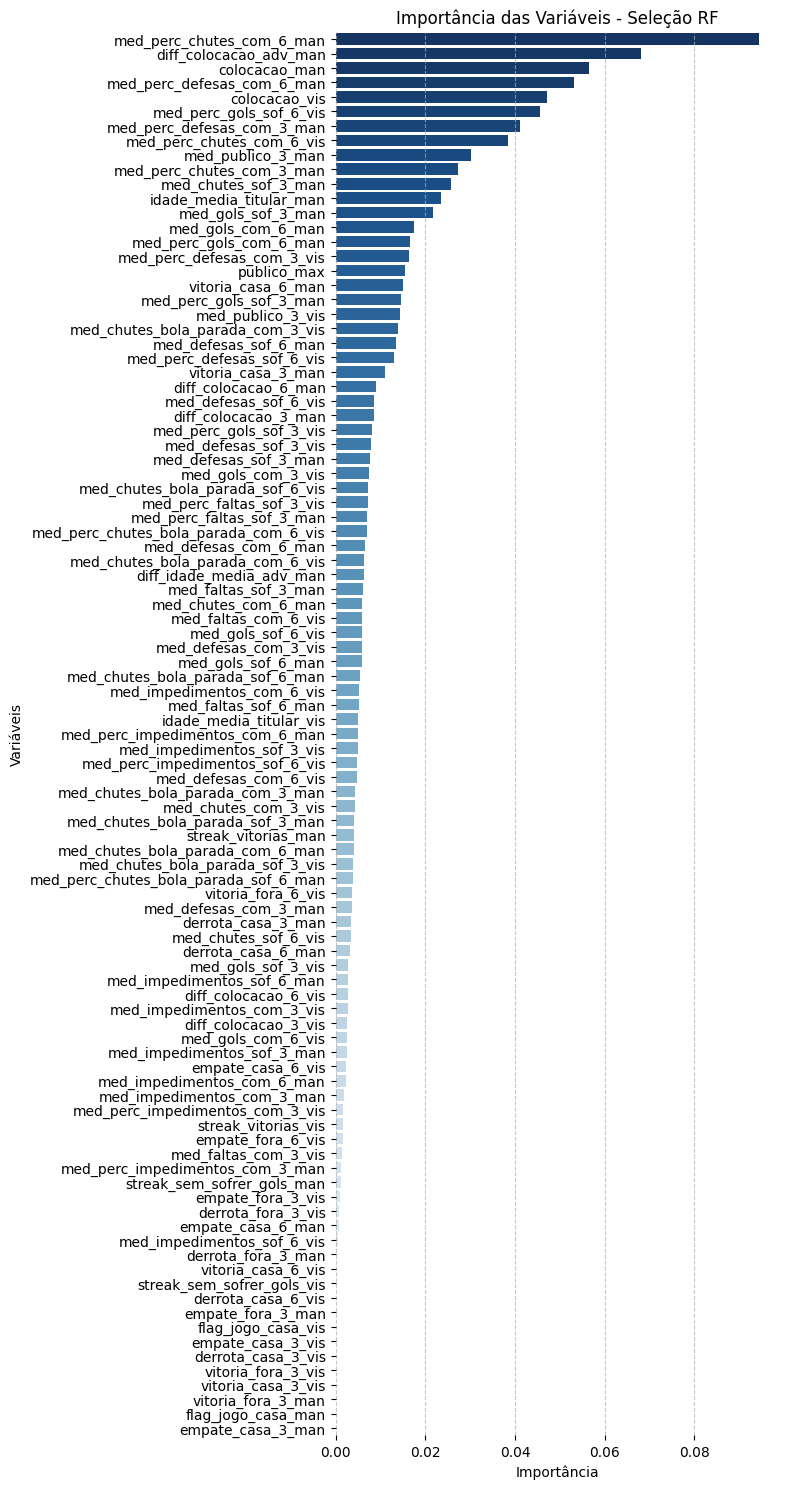

In [26]:
# RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42) # Mudar para 3 se possivel

rf_model.fit(df_filter, y_train)

feature_importances = pd.DataFrame({'VAR': df_filter.columns, 'IMP': rf_model.feature_importances_})

plt.figure(figsize=(8, 15))
sns.barplot(data=feature_importances.sort_values(by='IMP', ascending=False), x='IMP', y='VAR', palette='Blues_r')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis - Seleção RF')
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Observa-se claramente que as importâncias estão concentradas nas primeiras 8 variáveis. Assim, podemos adotar um corte na importancia de 0.035

In [28]:
feature_importances['RF_SEL'] = 0
feature_importances.loc[feature_importances['IMP']>0.035, 'RF_SEL'] = 1

In [29]:
feature_importances[feature_importances['RF_SEL']==1].sort_values(by='IMP',ascending=False)

,VAR,IMP,RF_SEL
17,med_perc_chutes_com_6_man,0.094372,1
5,diff_colocacao_adv_man,0.068032,1
1,colocacao_man,0.056617,1
27,med_perc_defesas_com_6_man,0.053201,1
49,colocacao_vis,0.047235,1
58,med_perc_gols_sof_6_vis,0.045582,1
26,med_perc_defesas_com_3_man,0.041163,1
63,med_perc_chutes_com_6_vis,0.038385,1


Agora, vamos observar como se comporta o AUC Score de um modelo RF baseline à medida que vamos retirando as variáveis por ordem crescente de importância.
Para este teste, vamos utilizar todas as variáveis.

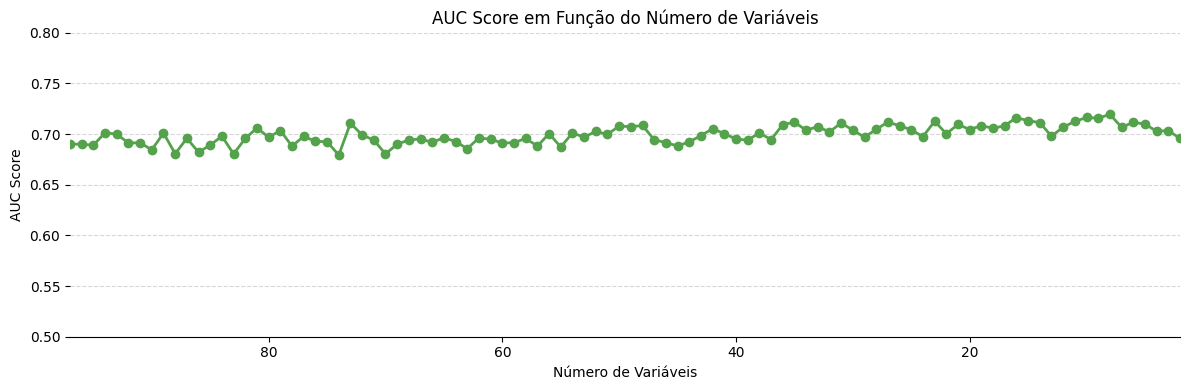

In [30]:
feat_desc = feature_importances.sort_values(by='IMP',ascending=False)['VAR'].to_list()
num_features_list = []
auc_list = []

for i in range(len(feat_desc),1,-1):
    
    selected_features_subset = feat_desc[:i]
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
    rf_model.fit(df_filter[selected_features_subset], y_train)    
    y_pred = rf_model.predict(X_sel_test[selected_features_subset])
    y_pred_proba = rf_model.predict_proba(X_sel_test[selected_features_subset])[:,1]
    
    auc = roc_auc_score(y_test, y_pred_proba)    
    num_features_list.append(i)
    auc_list.append(auc)

plt.figure(figsize=(12, 4))
plt.plot(num_features_list, auc_list, marker='o', linestyle='-', linewidth=2, color='#54a24b')
plt.xlabel('Número de Variáveis')
plt.ylabel('AUC Score')
plt.title('AUC Score em Função do Número de Variáveis')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
# plt.grid(True)
sns.despine(left=True)
plt.xlim(np.max(num_features_list), np.min(num_features_list))
plt.ylim(0.5, 0.8)

plt.tight_layout()
plt.show()

In [31]:
df_compara_sel = pd.merge(df_anova, feature_importances, on='VAR', how='inner')
df_compara_sel.sort_values(by='IMP',ascending=False, inplace=True)
df_compara_sel.head(20)

,VAR,F-Score,P-Valor,SEL,IMP,RF_SEL
17,med_perc_chutes_com_6_man,37.781580,1.111924e-09,1,0.094372,1
5,diff_colocacao_adv_man,86.280118,8.348423e-20,1,0.068032,1
1,colocacao_man,58.350752,4.821110e-14,1,0.056617,1
27,med_perc_defesas_com_6_man,37.448823,1.311184e-09,1,0.053201,1
49,colocacao_vis,32.839902,1.297472e-08,1,0.047235,1
58,med_perc_gols_sof_6_vis,25.246055,5.902928e-07,1,0.045582,1
26,med_perc_defesas_com_3_man,25.890737,4.259223e-07,1,0.041163,1
63,med_perc_chutes_com_6_vis,22.252240,2.704285e-06,1,0.038385,1
6,med_publico_3_man,29.981032,5.425711e-08,1,0.030182,0
16,med_perc_chutes_com_3_man,25.269577,5.833006e-07,1,0.027351,0


In [32]:
vars_sel = df_compara_sel[(df_compara_sel['SEL']==1) & (df_compara_sel['RF_SEL']==1)]['VAR'].to_list()

As variáveis selecionadas com intersecção do método univariado por ANOVA e baseado em modelo por RandomForest são as mesmas

In [33]:
vars_sel

['med_perc_chutes_com_6_man',
 'diff_colocacao_adv_man',
 'colocacao_man',
 'med_perc_defesas_com_6_man',
 'colocacao_vis',
 'med_perc_gols_sof_6_vis',
 'med_perc_defesas_com_3_man',
 'med_perc_chutes_com_6_vis']

Uma vez que temos as variáveis finais, podemos criar um preprocessor final para utilizar de pipeline para dados futuros.

OBS: As variáveis time_enc e time_adversario_enc foram retiradas de forma a evitar overfitting ou ocasionar um viés em relação ao time vs. time adversário. Assim, manteremos apenas o tecnico como variável encoded.

In [34]:
vars_final = [
    'med_perc_chutes_com_6_man',
    'diff_colocacao_adv_man',
    'colocacao_man',
    'med_perc_defesas_com_6_man',
    'colocacao_vis',
    'med_perc_gols_sof_6_vis',
    'med_perc_defesas_com_3_man',
    'med_perc_chutes_com_6_vis'
 ]

num_finais = [ 
    'med_perc_chutes_com_6_man',
    'diff_colocacao_adv_man',
    'colocacao_man',
    'med_perc_defesas_com_6_man',
    'colocacao_vis',
    'med_perc_gols_sof_6_vis',
    'med_perc_defesas_com_3_man',
    'med_perc_chutes_com_6_vis'
 ]

cat_ord_finais = [
 
]



preprocessor_final = cria_pipeline(num_finais, cat_ord_finais)
preprocessor_final.fit(X_train[vars_final])
joblib.dump(preprocessor_final, '../artifacts/preprocessor.pkl')

X_train_f = preprocessor_final.transform(X_train[vars_final])
# X_train_f.columns = X_train[vars_final].columns

X_test_f = preprocessor_final.transform(X_test[vars_final])
# X_test_f.columns = X_test[vars_final].columns

### Treinamento do Modelo

Para avaliar a performance do Modelo, precisamos treiná-lo utilizando uma métrica de maximização que será o Log Loss. 

Log Loss mede a distância entre as probabilidades previstas pelo modelo e as probabilidades reais e é uma métrica útil para avaliar modelos de classificação porque ela penaliza previsões incorretas.

`Log Loss = -1/N * sum(y * log(p) + (1 - y) * log(1 - p))`

In [35]:
# Juntando a variável resposta nos dados de treino 
df_train_f = pd.concat([X_train_f, y_train], axis=1)

In [36]:
df_train_f.shape

(1081, 9)

In [42]:
n_folds = 4

tamanho_fold = int(len(df_train_f)/n_folds)

partes = [df_train_f.iloc[i*tamanho_fold:(i+1)*tamanho_fold] for i in range(n_folds)]

for i in range(n_folds):

    df = df_train_f.iloc[i*tamanho_fold:(i+1)*tamanho_fold]
    pct70 = int(len(df)*0.7)
    df_train_aux = df.iloc[:pct70]
    df_test_aux = df.iloc[pct70:]

    print(f'TREINO: {len(df_train_aux)}, TESTE: {len(df_test_aux)}, SOMA: {len(df_train_aux) + len(df_test_aux)}')

TREINO: 189, TESTE: 81, SOMA: 270
TREINO: 189, TESTE: 81, SOMA: 270
TREINO: 189, TESTE: 81, SOMA: 270
TREINO: 189, TESTE: 81, SOMA: 270


In [43]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [49]:
def objective(trial, model_name):
    model = None

    model_seed = 42

    if model_name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 5),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 300),            
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            random_state=model_seed
        )
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(
            C=trial.suggest_float('C', 1e-3, 10, log=True),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga']),
            max_iter=trial.suggest_int('max_iter', 100, 5000),
            # tol=trial.suggest_float('tol', 1e-4, 1e-2, log=True),                        
            random_state=model_seed
        )
    elif model_name == 'LGBM':
        model = LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            max_depth=trial.suggest_int('max_depth', 1, 8),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            num_leaves=trial.suggest_int('num_leaves', 10, 150),
            min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 10, 200),            
            bagging_fraction=trial.suggest_float('bagging_fraction', 0.01, 1.0),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
            verbose=-1,
            random_state=model_seed
        )
    elif model_name == 'NaiveBayes':
        model = GaussianNB(
            var_smoothing=trial.suggest_float('var_smoothing', 1e-9, 1e-4, log=True)
        )
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=trial.suggest_int('n_estimators', 50, 1000),
            learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
            random_state=model_seed
        )
    elif model_name == 'KNN':
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 20),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            p=trial.suggest_int('p', 1, 2)
        )
    elif model_name == 'SVC':
        model = SVC(
            C=trial.suggest_float('C', 1e-3, 10, log=True),
            # kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
            kernel=trial.suggest_categorical('kernel', ['linear']),
            # gamma=trial.suggest_float('gamma', 1e-3, 1e3, log=True),
            gamma=trial.suggest_float('gamma', 1e-3, 10, log=True),
            shrinking=trial.suggest_categorical('shrinking', [True, False]), 
            probability=trial.suggest_categorical('probability', [True]),            
            random_state=model_seed
        )
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 6),
            min_samples_split=trial.suggest_int('min_samples_split', 5, 100),
            max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 30),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state=model_seed
        )

    n_folds = 4

    tamanho_fold = int(len(df_train_f)/n_folds)

    metrics_folds = []  
    for i in range(n_folds):

        df = df_train_f.iloc[i*tamanho_fold:(i+1)*tamanho_fold]
        pct70 = int(len(df)*0.7)
        train = df.iloc[:pct70]
        valid = df.iloc[pct70:]
        
        X_train = train.drop(['vitoria'],axis=1)
        y_train = train['vitoria']
        
        X_valid = valid.drop(['vitoria'],axis=1)
        y_valid = valid['vitoria']      

        model.fit(X_train, y_train)        
        y_pred_proba = model.predict_proba(X_valid)[:, 1]       
        y_pred =  model.predict(X_valid)
        
        result = log_loss(y_valid, y_pred_proba)
        metrics_folds.append(result)
               
    return np.mean(metrics_folds)  

In [51]:
# models = ['RandomForest', 'LogisticRegression', 'LGBM', 'NaiveBayes', 'AdaBoostClassifier', 'KNN', 'SVC', 'DecisionTree']
models = ['RandomForest', 'LogisticRegression', 'LGBM', 'SVC', 'DecisionTree']

comparison_df = pd.DataFrame(columns=['model', 'best_params', 'best_value'])

for model_name in models:

    print(f'------ {model_name} ------')

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction='minimize', sampler=sampler)

    study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

    best_params = study.best_params
    print(f'Melhores parametros: {best_params}')
    best_value = round(study.best_value,4)
    print(f'Melhor valor  {best_value}')

    df_aux = pd.DataFrame({
        'model': [model_name],
        'best_params': [best_params],
        'best_value': [best_value]
    })

    comparison_df = pd.concat([comparison_df, df_aux],ignore_index=True)

    del df_aux

------ RandomForest ------


Melhores parametros: {'n_estimators': 702, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 38, 'min_samples_leaf': 14, 'bootstrap': True}
Melhor valor  0.5822
------ LogisticRegression ------
Melhores parametros: {'C': 1.1095052608809104, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 1197}
Melhor valor  0.5822
------ LGBM ------
Melhores parametros: {'n_estimators': 406, 'max_depth': 1, 'learning_rate': 0.004237334042171262, 'num_leaves': 40, 'min_data_in_leaf': 12, 'bagging_fraction': 0.5508309431945917, 'reg_alpha': 0.4509535238207118, 'reg_lambda': 0.0010016474801699444}
Melhor valor  0.5964
------ SVC ------
Melhores parametros: {'C': 0.0013730010833586227, 'kernel': 'linear', 'gamma': 0.21501255938852593, 'shrinking': True, 'probability': True}
Melhor valor  0.5974
------ DecisionTree ------
Melhores parametros: {'max_depth': 1, 'min_samples_split': 10, 'max_leaf_nodes': 27, 'criterion': 'entropy'}
Melhor valor  0.6299


In [52]:
comparison_df.sort_values(by='best_value',ascending=True)

,model,best_params,best_value
0,RandomForest,"{'n_estimators': 702, 'max_depth': 4, 'criteri...",0.5822
1,LogisticRegression,"{'C': 1.1095052608809104, 'penalty': 'l2', 'so...",0.5822
2,LGBM,"{'n_estimators': 406, 'max_depth': 1, 'learnin...",0.5964
3,SVC,"{'C': 0.0013730010833586227, 'kernel': 'linear...",0.5974
4,DecisionTree,"{'max_depth': 1, 'min_samples_split': 10, 'max...",0.6299


O modelo que apresentou desempenho superior após a otimização de seus hiperparâmetros foi a Regressão Logistica. Agora, procederemos à sua instanciação e avaliação no conjunto de teste.

In [274]:
model_f = LogisticRegression(C=1.1095052608809104,    
                             penalty='l2',         
                            solver='saga',
                            max_iter=1197,
                            random_state=42)


model_f.fit(X_train_f, y_train)
pred_train = model_f.predict(X_train_f)
pred_proba_train = model_f.predict_proba(X_train_f)[:,1]
pred_f = model_f.predict(X_test_f)
pred_proba_test = model_f.predict_proba(X_test_f)[:,1]


print('--- TREINO ---')
print(f'''ROC: {roc_auc_score(y_train, pred_proba_train)}''')


print('--- TESTE ---')
print(f'''ROC: {roc_auc_score(y_test, pred_proba_test)}''')

--- TREINO ---
ROC: 0.7000780422973798
--- TESTE ---
ROC: 0.7250341122292342


In [273]:
joblib.dump(model_f, '../artifacts/model_f.pkl')

['../artifacts/model_f.pkl']

In [58]:
df_mod = data_full[data_full['ano_campeonato']>=2018][vars_final+['vitoria_man', 'AvgH',	'AvgD'	,'AvgA', 'ano_campeonato']]
df_mod[vars_final] = preprocessor_final.transform(df_mod[vars_final])

df_train_f = df_mod[(df_mod['ano_campeonato']>=2018) & (df_mod['ano_campeonato']<2022)]
df_test_f = df_mod[(df_mod['ano_campeonato']>=2022)]

In [59]:
df_test_f['pred_vitoria'] = model_f.predict_proba(df_test_f[vars_final])[:, 1]
df_test_f['pred_derrota'] = model_f.predict_proba(df_test_f[vars_final])[:, 0] 
df_test_f['prob_impl_vitoria'] = 1 / df_test_f['AvgH']
df_test_f['prob_impl_derrota'] = 1 / df_test_f['AvgA']

df_train_f['pred_vitoria'] = model_f.predict_proba(df_train_f[vars_final])[:, 1]
df_train_f['pred_derrota'] = model_f.predict_proba(df_train_f[vars_final])[:, 0] 
df_train_f['prob_impl_vitoria'] = 1 / df_train_f['AvgH']
df_train_f['prob_impl_derrota'] = 1 / df_train_f['AvgA']

In [60]:
df_mod['pred_vitoria'] = model_f.predict_proba(df_mod[vars_final])[:, 1]
df_mod['pred_derrota'] = model_f.predict_proba(df_mod[vars_final])[:, 0]

df_mod['prob_impl_vitoria'] = 1 / df_mod['AvgH']
df_mod['prob_impl_derrota'] = 1 / df_mod['AvgA']


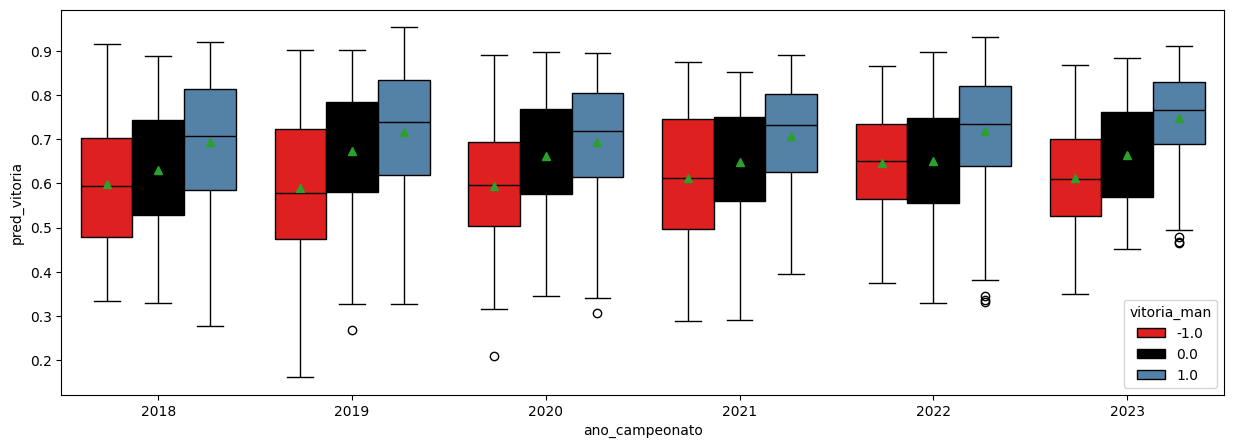

In [61]:
plt.figure(figsize=(15,5))

sns.boxplot(data=df_mod, y='pred_vitoria', x='ano_campeonato', hue='vitoria_man', palette=['red','black', 'steelblue'], showmeans=True)

plt.show()

Distribuição da probabilidade do Modelo para vitoria do time mandante agrupado pelo resultado.

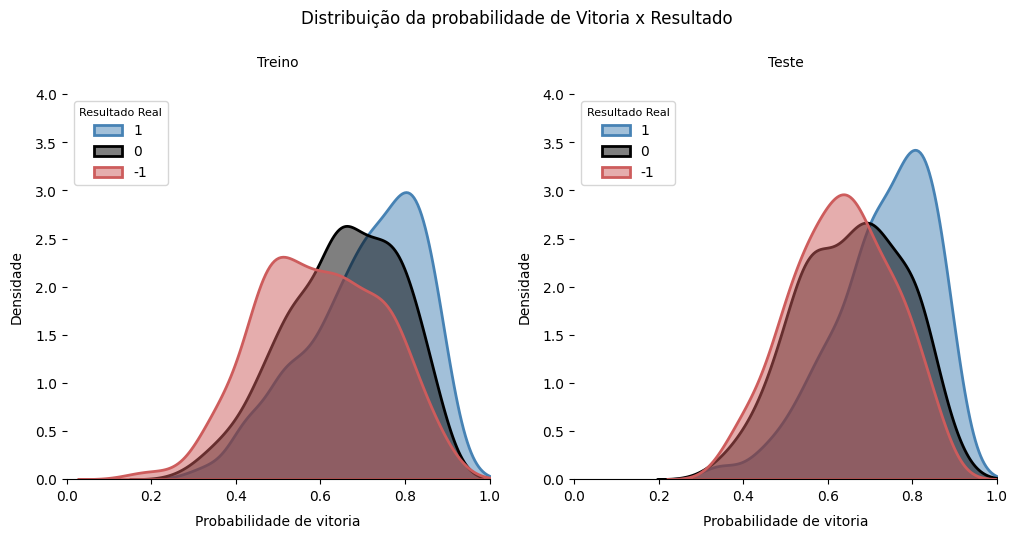

Treino


pred_vitoria                                                    \
                   count      mean       std       min       25%       50%   
vitoria_man                                                                  
-1.0               358.0  0.599110  0.147270  0.161653  0.485528  0.593688   
 0.0               424.0  0.653416  0.134573  0.269191  0.553681  0.661437   
 1.0               723.0  0.703345  0.136641  0.276444  0.615876  0.726408   

                                 
                  75%       max  
vitoria_man                      
-1.0         0.715993  0.916304  
 0.0         0.761369  0.901441  
 1.0         0.810970  0.953595

Teste


pred_vitoria                                                    \
                   count      mean       std       min       25%       50%   
vitoria_man                                                                  
-1.0               164.0  0.633080  0.119873  0.349002  0.548216  0.633745   
 0.0               176.0  0.655555  0.125850  0.330166  0.561882  0.661372   
 1.0               286.0  0.730467  0.120205  0.331154  0.657647  0.752411   

                                 
                  75%       max  
vitoria_man                      
-1.0         0.722247  0.867724  
 0.0         0.756714  0.898022  
 1.0         0.822553  0.932354

In [66]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

sns.kdeplot(df_train_f, 
            x='pred_vitoria', 
            hue='vitoria_man', 
            ax=axs[0],
            fill=True, 
            common_norm=False,
            alpha=0.5, 
            linewidth=2,
            palette=['indianred','black', 'steelblue']
            )

axs[0].set_xlabel('Probabilidade de vitoria', labelpad=8)
axs[0].set_ylabel('Densidade', labelpad=8)
axs[0].set_title('Treino', fontsize=10, pad=20)
axs[0].legend(title='Resultado Real', labels=['1','0','-1'], title_fontsize=8, loc='upper left')
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 4)
sns.despine(ax=axs[0], left=True)    

sns.kdeplot(df_test_f, 
            x='pred_vitoria', 
            hue='vitoria_man', 
            ax=axs[1],
            fill=True, 
            common_norm=False,
            alpha=0.5, 
            linewidth=2,
            palette=['indianred','black', 'steelblue']
            )

axs[1].set_xlabel('Probabilidade de vitoria', labelpad=8)
axs[1].set_ylabel('Densidade', labelpad=8)
axs[1].set_title('Teste', fontsize=10, pad=20)
axs[1].legend(title='Resultado Real', labels=['1','0','-1'], title_fontsize=8, loc='upper left')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 4)
sns.despine(ax=axs[1], left=True)               

plt.suptitle('Distribuição da probabilidade de Vitoria x Resultado', fontsize=12, y=1.05)
plt.show()

print('Treino')
display(df_train_f.groupby('vitoria_man')[['pred_vitoria']].describe())

print('Teste')
display(df_test_f.groupby('vitoria_man')[['pred_vitoria']].describe())

### Teste de Rentabilidade em apostas esportivas com o uso do Modelo

- Vamos simular apostas para os jogos no conjunto de teste, de forma a avaliar a rentabilidade.
- As apostas serão feitas utilizando o Critério de Kelly: uma abordagem estatística que leva em consideração os Odds, a probabilidade do Modelo e o Saldo.
- Vamos utilizar frações de Kelly para essas apostas (constante K), que tem por objetivo reduzir em K o valor apostado com o intuito de realizar apostas menos arrojadas.
- O Saldo de início será de R$ 1000,00

In [67]:
def kelly_criterion_fraction(probability, odds, fraction=1.0):
    """
    Calcula a fração do Critério de Kelly para o dimensionamento ideal da aposta.

    Parâmetros:
    - odds: Odds decimais (por exemplo, 2.0 para odds iguais, 3.0 para odds de 2:1, etc.).
    - probabilidade: Probabilidade de vitória (deve estar entre 0 e 1).
    - fração: Fração do bankroll atual a considerar (padrão é 1.0).

    Retorna:
    - A fração do bankroll atual a apostar de acordo com o Critério de Kelly.
    """
    b = odds - 1 
    q = 1 - probability
    kelly = (b * probability - q) / b
    
    kelly_fraction = fraction*kelly

    return kelly_fraction

In [68]:
# Armazena em arrays
preds_prob_w = df_test_f['pred_vitoria'].values
preds_prob_l = df_test_f['pred_derrota'].values
odds_homewin = df_test_f['AvgH'].values
odds_awaywin = df_test_f['AvgA'].values
y_true = df_test_f['vitoria_man'].values

#### Primeira Simulação:

Apostas somente na  vitoria do time mandante:
- O tamanho da aposta será calculado pelo Critério de Kelly, utilizando Odds da vitoria.
- A aposta apenas será realizada se o valor da fração de kelly for positivo.
- O valor máximo de cada aposta será de R$ 100,00.

Lucro total (k = 1): -1000.0000000000002
Lucro total (k = 0.5): -999.9980827105311
Lucro total (k = 0.25): -973.2629366082612
Lucro total (k = 0.125): -650.9616385679494


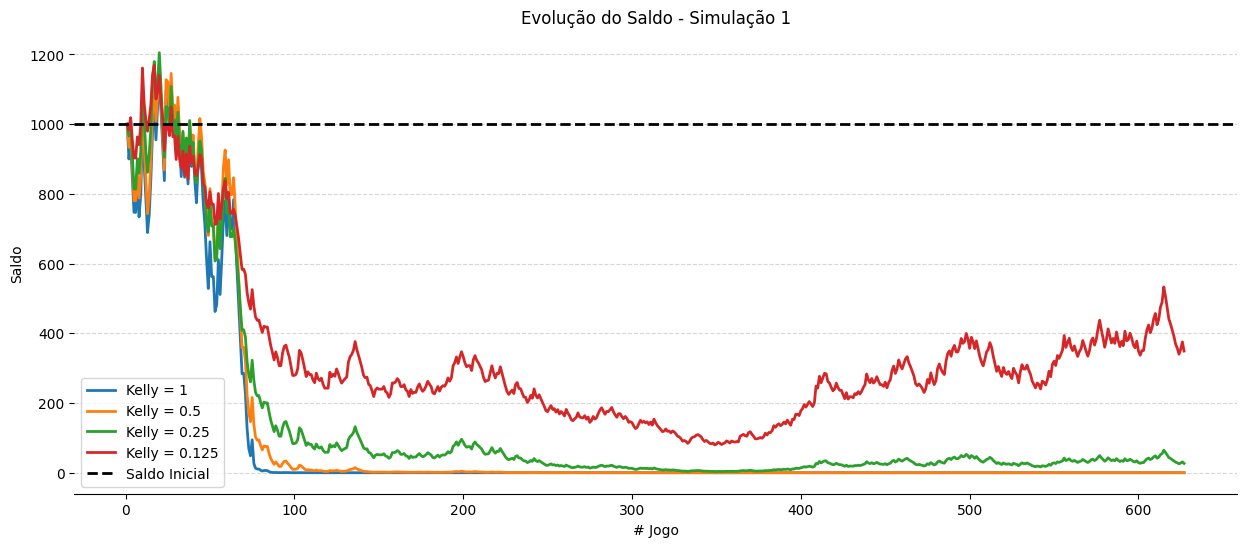

,valor_total_apostado,%_jogos_apostados,qtd_apostas,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi,%_roi_medio,%_drawdown,%_ror
0,6518.38,96.49,605,100.0,45.45,259.00,1.000,0.00,-100.00,-10.98,100.00,-382.70
1,6435.31,96.49,605,100.0,45.45,259.00,0.500,0.00,-100.00,-10.98,100.00,-358.29
2,7179.17,96.49,605,100.0,45.45,192.00,0.250,26.74,-97.33,-10.98,99.72,-361.64
3,10106.88,96.49,605,100.0,45.45,163.72,0.125,349.04,-65.10,-10.98,93.17,-289.72


In [249]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas, rois = [], [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
        stake_w = f_star_w*bankroll
        
        if stake_w < 0:            
            stake = 0 # Nao realiza aposta  
            flag_aposta = 0 
        else:
            stake = stake_w
            flag_aposta = 1
        
        stake = np.min([100,stake])
        bankroll -= stake # Desconta valor da aposta

        if outcome == 1 and stake > 0:            
            aposta_ganha = 1
            win_value = stake * (odds_w - 1)
            lucros.append(win_value)
            bankroll += stake + win_value
            roi = win_value/stake   
            rois.append(roi)       
        else:
            aposta_ganha = 0
            lucros.append(-stake)
            roi = -1   
            rois.append(roi)

        bankroll = np.max([0,bankroll])
       
        apostas.append(flag_aposta)
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    print(f'Lucro total (k = {k}): {np.sum(lucros)}')
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    drawdown = (np.max(bankroll_history) - np.min(bankroll_history)) / np.max(bankroll_history)
    roi_avg = np.mean(rois)
    desv_padrao_sld = np.std(bankroll_history)
    roi = (bankroll_history[-1]/bankroll_history[0] -1)
    ror = (bankroll_history[-1] - bankroll_history[0]) / desv_padrao_sld
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'qtd_apostas': [round(qtd_jogos_apostados,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi*100,2)],
                        '%_roi_medio': [round(roi_avg*100,2)],
                        '%_drawdown' : [round(drawdown*100,2)],
                        '%_ror': [round(ror*100,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Simulação 1')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

Resultados - Simulação 1:
-   Apostar apenas na vitoria trouxe retornos negativos em todas as frações de Kelly (K).
-   96.5% dos jogos foram apostados, sendo que 46% destes foram em apostas ganhas.
-   Apesar dos resultados negativos, o cenário com K = 0.125 resultou no menor prejuízo (ROI de -65%).

#### Segunda Simulação:

Apostas na vitoria ou derrota do time mandante:
- O tamanho da aposta será calculado pelo Critério de Kelly, utilizando Odds da vitoria ou derrota do time mandante.
- Será realizada apenas uma aposta por jogo (ou na derrota ou vitoria) e não simultaneamente.
- A aposta será no time cujo valor de Kelly for maior (melhor recomendação de acordo com a Probabilidade e Odds).
- O valor máximo de cada aposta será de R$ 100,00.

Lucro total (k = 1): -999.9999999999998
Lucro total (k = 0.5): -998.2694691560373
Lucro total (k = 0.25): 122.52138034903726
Lucro total (k = 0.125): 854.0901810927679


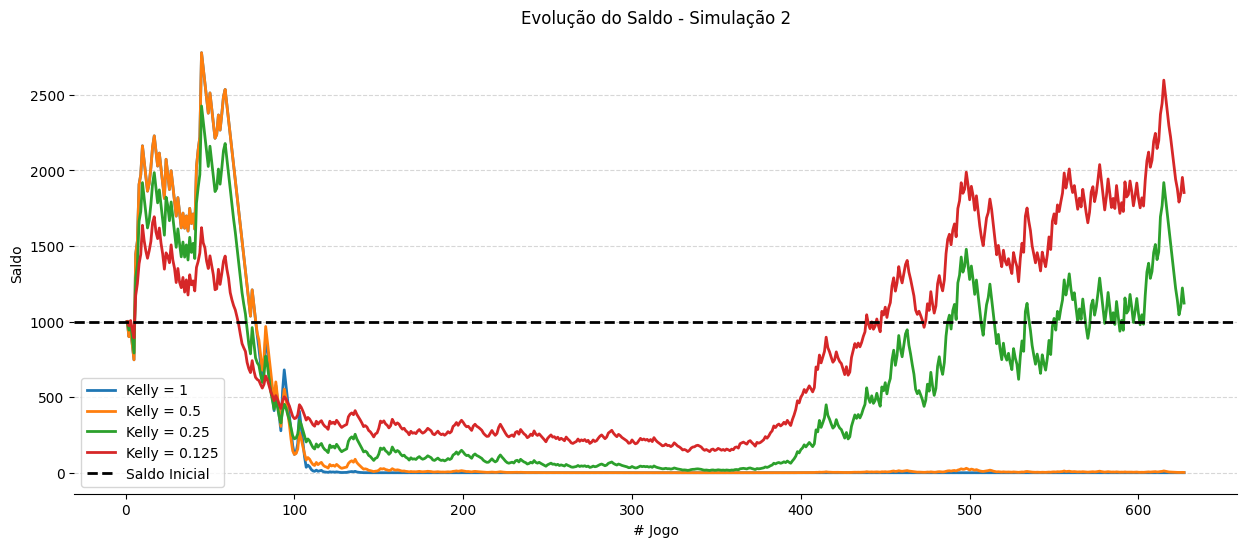

,valor_total_apostado,%_jogos_apostados,qtd_apostas,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi,%_roi_medio,%_drawdown,%_ror
0,10557.00,99.84,626,100.0,46.01,699.00,1.000,0.00,-100.00,6.96,100.00,-157.15
1,10721.12,99.84,626,100.0,46.01,699.00,0.500,1.73,-99.83,6.96,100.00,-157.36
2,27666.92,99.84,626,100.0,46.01,497.17,0.250,1122.52,12.25,6.96,99.39,20.65
3,25386.00,99.84,626,100.0,46.01,280.08,0.125,1854.09,85.41,6.96,94.63,132.31


In [250]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000 
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas, rois = [], [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
        stake_w = f_star_w*bankroll if f_star_w > 0 else 0

        f_star_l = kelly_criterion_fraction(prob_l, odds_l, k) # Kelly apostando na derrota
        stake_l = f_star_l*bankroll if f_star_l > 0 else 0
        
        if stake_w > stake_l:
            flag_aposta = 1
            stake = stake_w
            stake_l = 0            
        elif stake_l > stake_w:
            flag_aposta = 1
            stake = stake_l
            stake_w = 0         
        else:              
            flag_aposta = 0
            stake_w = 0
            stake_l = 0
            stake = 0 
        
        stake = np.min([100,stake])
        bankroll -= stake # Desconta valor da aposta        

        if outcome == 1 and stake_w > 0:            
            aposta_ganha = 1
            win_value = stake * (odds_w - 1)
            lucros.append(win_value)
            bankroll += stake + win_value
            roi = win_value/stake  
            rois.append(roi)  

        elif outcome == -1 and stake_l > 0:
            aposta_ganha = 1
            win_value = stake * (odds_l - 1)
            lucros.append(win_value)
            bankroll += stake + win_value 
            roi = win_value/stake  
            rois.append(roi)    
                 
        else:
            aposta_ganha = 0
            lucros.append(-stake)  
            roi = -1 
            rois.append(roi) 

        bankroll = np.max([0,bankroll])
       
        apostas.append(flag_aposta)
        stakes.append(stake)        
        apostas_ganhas.append(aposta_ganha)
        bankroll_history.append(bankroll)

    print(f'Lucro total (k = {k}): {np.sum(lucros)}')    
    
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    drawdown = (np.max(bankroll_history) - np.min(bankroll_history)) / np.max(bankroll_history)
    roi_avg = np.mean(rois)   
    desv_padrao_sld = np.std(bankroll_history)
    ganhos = np.sum(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1)
    ror = (bankroll_history[-1] - bankroll_history[0]) / desv_padrao_sld 
    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)

    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'qtd_apostas': [round(qtd_jogos_apostados,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi*100,2)],
                        '%_roi_medio': [round(roi_avg*100,2)],
                        '%_drawdown' : [round(drawdown*100,2)],
                        '%_ror': [round(ror*100,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Simulação 2')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

Resultados - Simulação 2:
-   Os cenários com Kelly de 0.25 e 0.125 trouxeram retornos positivos com 12.25% e 85.41%, respectivamente.
-   Aproximadamente 100% dos jogos foram apostados, sendo que 46% destes foram em apostas ganhas.

In [71]:
def kelly_criterion_fraction2(probability, odds):
   
    b = odds - 1  # Net odds received on the bet
    q = 1 - probability
    kelly = (b * probability - q) / b

    # Ensure the fraction is within the specified limits
    

    return kelly

#### Terceira Simulação:

Apostas na vitoria e derrota do time mandante:
- O tamanho da aposta será calculado pelo Critério de Kelly, utilizando Odds da vitoria e derrota do time mandante.
- As apostas serão realizadas tanto na vitoria quanto derrota do time mandante, de forma a diversificar e reduzir o risco.
- As apostas serão ponderadas pelo valor de Kelly e aplicada ao valor máximo da aposta para a rodadada.
- O valor máximo de cada aposta será de R$ 100,00.

Lucro total (k = 1): -999.9999999999998
Lucro total (k = 0.5): -999.8263175299435
Lucro total (k = 0.25): -666.2567978772055
Lucro total (k = 0.125): 314.2774583023287


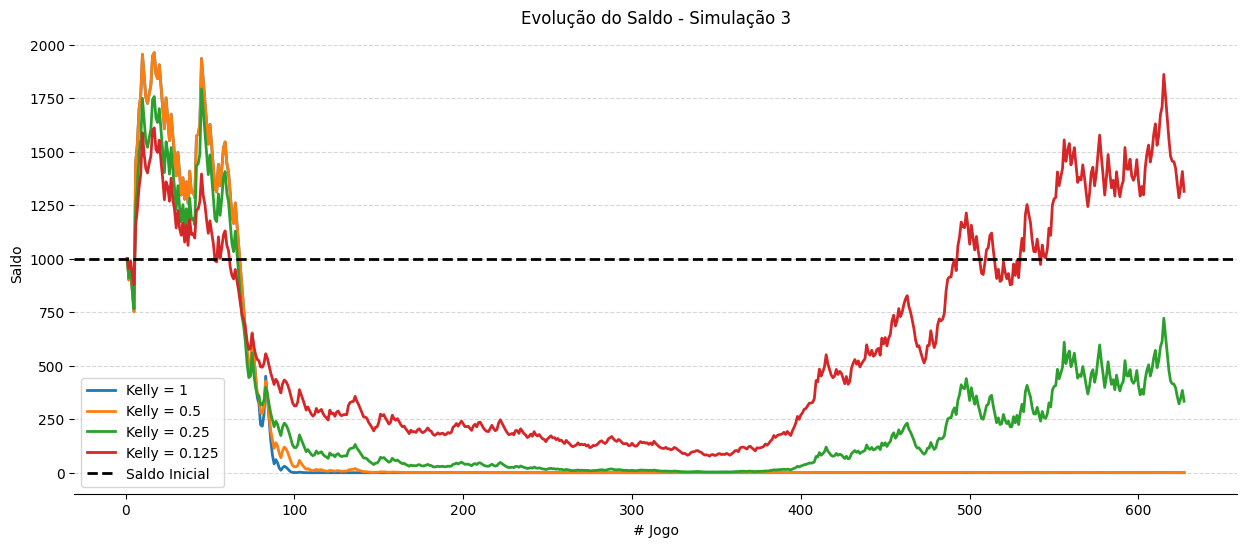

,valor_total_apostado,%_jogos_apostados,qtd_apostas,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi,%_roi_medio,%_drawdown,%_ror
0,8711.94,99.84,626,100.0,61.98,699.00,1.000,0.00,-100.00,-0.10,100.00,-210.81
1,8770.46,99.84,626,100.0,61.98,699.00,0.500,0.17,-99.98,-0.15,100.00,-211.10
2,16718.20,99.84,626,100.0,61.98,480.45,0.250,333.74,-66.63,-0.18,99.82,-162.06
3,21873.53,99.84,626,100.0,61.98,275.78,0.125,1314.28,31.43,-0.21,95.84,64.13


In [253]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas = [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k)
        f_star_w = f_star_w if f_star_w > 0 else 0
        stake_w = f_star_w*bankroll

        f_star_l = kelly_criterion_fraction(prob_l, odds_l, k)
        f_star_l = f_star_l if f_star_l > 0 else 0
        stake_l = f_star_l*bankroll

        pct_w = f_star_w / (f_star_w + f_star_l) # Proporção da aposta na vitoria
        pct_l = f_star_l / (f_star_w + f_star_l) # Proporção da aposta na derrota        

        stake_max = 100
        stake_w = np.min([stake_max,stake_w])
        stake_l = np.min([stake_max,stake_l])

        if (stake_w + stake_l) >= stake_max:
            stake_w = pct_w*stake_max
            stake_l = pct_l*stake_max 

        if stake_w > 0 or stake_l > 0:
            flag_aposta = 1                      
        else:              
            flag_aposta = 0            

        if stake_w > 0:            
            stakes.append(stake_w)
            bankroll -= stake_w 
            if outcome == 1:
                aposta_ganha = 1
                win_value = stake_w * (odds_w - 1)            
                lucros.append(win_value)
                bankroll += stake_w + win_value    
                roi = win_value/stake_w
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)
            else:
                aposta_ganha = 0
                lucros.append(-stake_w)   
                roi = -1
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)

        if stake_l > 0:            
            stakes.append(stake_l)
            bankroll -= stake_l 
            if outcome == -1:
                aposta_ganha = 1
                win_value = stake_l * (odds_l - 1)            
                lucros.append(win_value)
                bankroll += stake_l + win_value    
                roi = win_value/stake_l
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)
            else:
                aposta_ganha = 0
                lucros.append(-stake_l)   
                roi = -1
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)
            
        apostas.append(flag_aposta)
        bankroll = np.max([0,bankroll])
        bankroll_history.append(bankroll)

    print(f'Lucro total (k = {k}): {np.sum(lucros)}')    
    
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    drawdown = (np.max(bankroll_history) - np.min(bankroll_history)) / np.max(bankroll_history)
    roi_avg = np.mean(rois)    
    desv_padrao_sld = np.std(bankroll_history)
    ganhos = np.sum(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1)
    ror = (bankroll_history[-1] - bankroll_history[0]) / desv_padrao_sld 

    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)


    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'qtd_apostas': [round(qtd_jogos_apostados,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi*100,2)],
                        '%_roi_medio': [round(roi_avg*100,2)],
                        '%_drawdown' : [round(drawdown*100,2)],
                        '%_ror': [round(ror*100,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Simulação 3')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

Resultados - Simulação 3:
-   O cenário com K = 0.125 foi o único com retorno positivo (31.43%)
-   Aproximadamente 100% dos jogos foram apostados, com uma taxa de apostas ganhar de 62%, o que é um bom indicador.
-   O maior valor ganho nas apostas foi de R$ 699 para K = 1 e K = 0.5. No entanto, o ROI final foi negativo. 

### Estratégias:

Em vista a buscar melhores resultados, vamos realizar uma comparação da probabilidade do Modelo com a probabilidade implicita (através dos Odds). 

Além disso, vamos estabelecer novas regras baseada nesses dados para realizar novas estratégias.

Relação entre probabilidade do Modelo para vitoria do time mandante ou visitante em comparação com a probabilidade implicita dos Odds

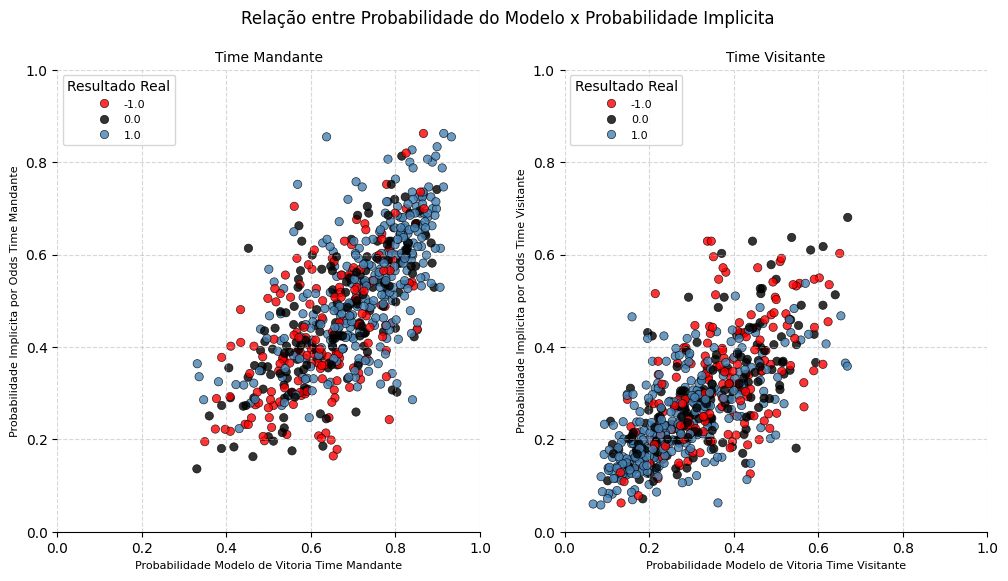

In [260]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# G1
sns.scatterplot(data=df_test_f, 
                x='pred_vitoria', 
                y='prob_impl_vitoria',
                hue='vitoria_man', 
                ax=axs[0],
                alpha=0.8, 
                edgecolor='black', 
                linewidths=0.5, 
                palette=['red','black', 'steelblue'])

axs[0].set_xlabel('Probabilidade Modelo de Vitoria Time Mandante', fontsize=8)
axs[0].set_ylabel('Probabilidade Implicita por Odds Time Mandante', fontsize=8)
axs[0].set_title('Time Mandante', fontsize=10)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 1)
axs[0].grid(True, linestyle='--', alpha=0.5)  # Add a grid for visual guidance
axs[0].legend(title='Resultado Real', loc='upper left', fontsize=8)

# G2
sns.scatterplot(data=df_test_f, 
                x='pred_derrota', 
                y='prob_impl_derrota',
                hue='vitoria_man', 
                ax=axs[1],
                alpha=0.8, 
                edgecolor='black', 
                linewidths=0.5, 
                palette=['red','black', 'steelblue'])

axs[1].set_xlabel('Probabilidade Modelo de Vitoria Time Visitante', fontsize=8)
axs[1].set_ylabel('Probabilidade Implicita por Odds Time Visitante', fontsize=8)
axs[1].set_title('Time Visitante', fontsize=10)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 1)
axs[1].grid(True, linestyle='--', alpha=0.5)  # Add a grid for visual guidance
axs[1].legend(title='Resultado Real', loc='upper left', fontsize=8)

fig.suptitle('Relação entre Probabilidade do Modelo x Probabilidade Implicita', fontsize=12)

sns.despine(left=True)

plt.show()

Ao analisar as relações entre as probabilidades, podemos concluir que:

1. Vitoria Mandante:
    -   Para time mandante, uma Prob. Modelo >= 0.8 conseguiria segmentar bem os casos de **vitoria mandante** (resultado = 1.0 da plotagem à esquerda).
    -   Em contrapartida, para o time visitante, uma Prob. Modelo <= 0.25 e Prob. Implicita <= 0.3 separa bem os casos de **vitoria mandante** (resultado = 1.0 da plotagem à direita).

2. Vitoria Visitante:
    -   Para time mandante, uma Prob. Modelo <= 0.7 e Prob. Implicita <= 0.4 segmenta parcialmente os casos de **vitoria visitante** (resultado = -1 da plotagem à esquerda).
    -   Para time visitante, uma Prob. Modelo > 0.4 ou Prob. Implicita > 0.4 segmentaria razoavelmente bem os casos de **vitoria visitante**. (resultado = -1, da plotagem à direita)

Para encontrarmos os melhores cortes possíveis, podemos criar uma Árvore de Decisão com profundidade baixa. Para isso vamos criar mais duas variáveis que seriam a diferença entre a probabilidade do nosso modelo em relação à probabilidade implicita em odds.

In [261]:
df_test_f['diff_prob_vitoria'] = df_test_f['pred_vitoria'] - df_test_f['prob_impl_vitoria']
df_test_f['diff_prob_derrota'] = df_test_f['pred_derrota'] - df_test_f['prob_impl_derrota']

df_train_f['diff_prob_vitoria'] = df_train_f['pred_vitoria'] - df_train_f['prob_impl_vitoria']
df_train_f['diff_prob_derrota'] = df_train_f['pred_derrota'] - df_train_f['prob_impl_derrota']

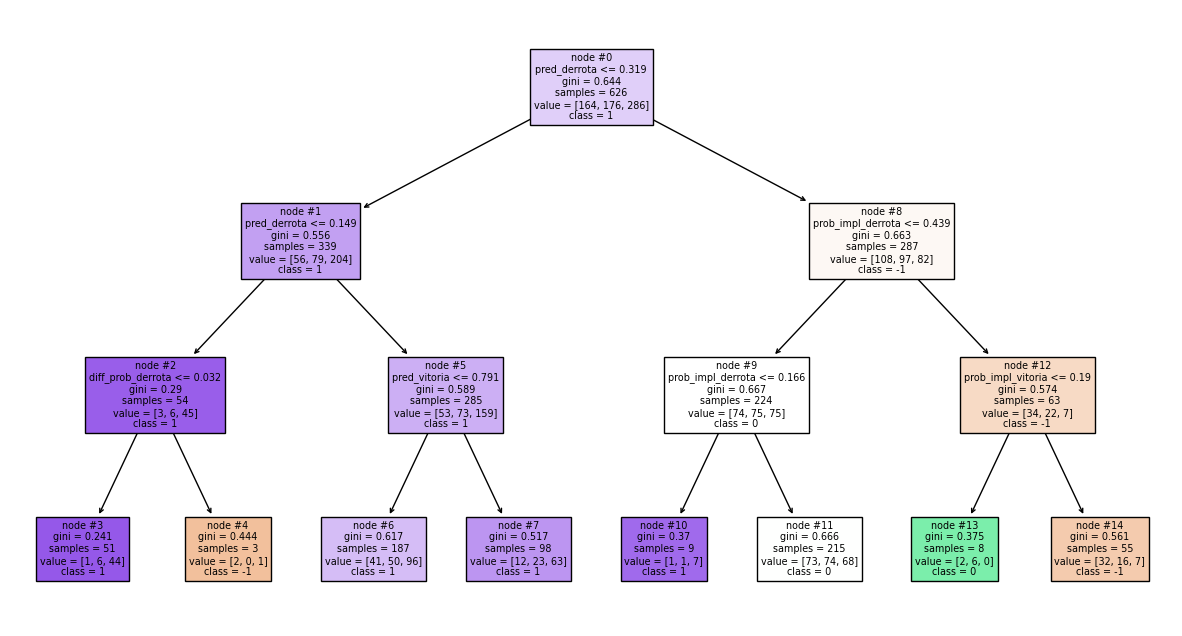

In [267]:
from sklearn import tree

X = df_test_f[['pred_vitoria', 'prob_impl_vitoria', 'pred_derrota', 'prob_impl_derrota', 'diff_prob_vitoria', 'diff_prob_derrota']]
# X = df_test_f[['pred_derrota', 'diff_prob_vitoria', 'diff_prob_derrota']]
y = df_test_f['vitoria_man']

treemodel = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1)
treemodel.fit(X, y)

plt.figure(figsize=(15, 8)) 
tree.plot_tree(treemodel, filled=True, feature_names=X.columns, proportion=False, node_ids=True, class_names=['-1','0','1'])
plt.show()

#### Simulação com Regras da Árvore:

Apostas na vitoria e derrota do time mandante:
- Os critérios de apostas serão os mesmos da simulação 3, exceto pela proporção das apostas nas quais serão de acordo com as regras conforme a Árvore de Decisão

-   Se prob derrota <= 0.3 ( ou prob vitoria > 0.7) - Node #1
    -   então apostar  majoritariamente na vitoria (90% do valor da aposta) e 10% na derrota.

-   Se prob_derrota > 0.3 e prob_impl_derrota <= 0.4 - Node #9
    -   então não apostar (equilibrio entre classes)

-   Se prob_derrota > 0.3 e prob_impl_derrota > 0.4 - Node #12
    -   apostar na derrota (70%)

Lucro total (k = 1): -999.994115710375
Lucro total (k = 0.5): -75.23618268667917
Lucro total (k = 0.25): 1111.2880758063009
Lucro total (k = 0.125): 1288.3482397459734


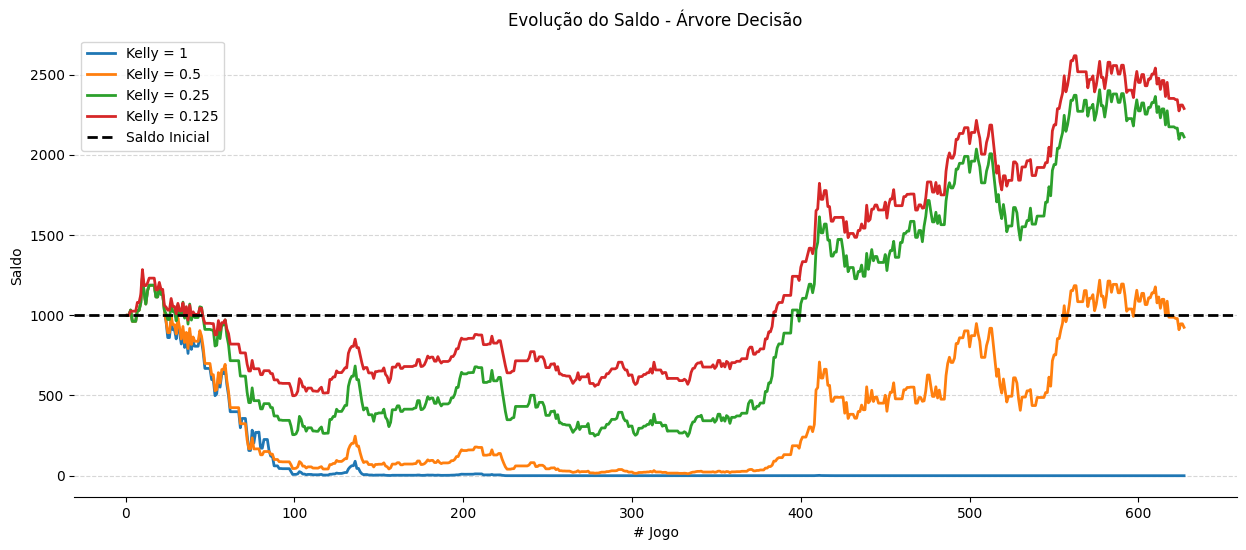

,valor_total_apostado,%_jogos_apostados,qtd_apostas,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi,%_roi_medio,%_drawdown,%_ror
0,5618.04,57.26,359,90.0,72.42,172.8,1.000,0.01,-100.00,-3.58,100.00,-369.13
1,19533.16,58.85,369,90.0,71.00,225.0,0.500,924.76,-7.52,-4.26,99.00,-19.11
2,25693.83,59.17,371,90.0,71.16,225.0,0.250,2111.29,111.13,-3.89,89.81,161.72
3,21947.91,57.58,361,90.0,72.30,225.0,0.125,2288.35,128.83,-3.41,80.95,195.48


In [271]:
kelly_fractions = [1, 0.5, 0.25, 0.125]
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:
    bankroll = 1000
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas, rois = [], [], [], [], []    
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):
        
        f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
        f_star_w = f_star_w if f_star_w > 0 else 0
        stake_w = f_star_w*bankroll

        f_star_l = kelly_criterion_fraction(prob_l, odds_l, k) # Kelly apostando na derrota
        f_star_l = f_star_l if f_star_l > 0 else 0
        stake_l = f_star_l*bankroll
             

        if prob_l <= 0.3:
            pct_w = 0.9
            pct_l = 0.1
        elif prob_l > 0.3 and (1/odds_l) <= 0.4:
            pct_w = 0
            pct_l = 0         
        else:
            pct_w = 0
            pct_l = 0.7

        stake_max = 100
        stake_w = np.min([stake_max,stake_w])
        stake_l = np.min([stake_max,stake_l])

        if (stake_w + stake_l) >= stake_max:
            stake_w = pct_w*stake_max
            stake_l = pct_l*stake_max
        else:
            stake_w = pct_w*(stake_w + stake_l)
            stake_l = pct_l*(stake_w + stake_l)

        
        if stake_w > 0 or stake_l > 0:
            flag_aposta = 1                      
        else:              
            flag_aposta = 0            
        
        if stake_w > 0:            
            stakes.append(stake_w)
            bankroll -= stake_w 
            if outcome == 1:
                aposta_ganha = 1
                win_value = stake_w * (odds_w - 1)            
                lucros.append(win_value)
                bankroll += stake_w + win_value    
                roi = win_value/stake_w
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)
            else:
                aposta_ganha = 0
                lucros.append(-stake_w)   
                roi = -1
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)

        if stake_l > 0:            
            stakes.append(stake_l)
            bankroll -= stake_l 
            if outcome == -1:
                aposta_ganha = 1
                win_value = stake_l * (odds_l - 1)            
                lucros.append(win_value)
                bankroll += stake_l + win_value    
                roi = win_value/stake_l
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)
            else:
                aposta_ganha = 0
                lucros.append(-stake_l)   
                roi = -1
                rois.append(roi)
                apostas_ganhas.append(aposta_ganha)
            
        apostas.append(flag_aposta)
        bankroll = np.max([0,bankroll])
        bankroll_history.append(bankroll)

    print(f'Lucro total (k = {k}): {np.sum(lucros)}')    
    
    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    drawdown = (np.max(bankroll_history) - np.min(bankroll_history)) / np.max(bankroll_history)
    roi_avg = np.mean(rois)    
    desv_padrao_sld = np.std(bankroll_history)
    ganhos = np.sum(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1)
    ror = (bankroll_history[-1] - bankroll_history[0]) / desv_padrao_sld 

    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)


    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'qtd_apostas': [round(qtd_jogos_apostados,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi*100,2)],
                        '%_roi_medio': [round(roi_avg*100,2)],
                        '%_drawdown' : [round(drawdown*100,2)],
                        '%_ror': [round(ror*100,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Árvore Decisão')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

Resultados - Simulação com Árvore:
-   O cenário com K = 0.125 teve o melhor retorno (128.83 %). O cenário com K = 0.5 também trouxe resultado positivo (111 %)
-   K = 0.5 praticamente ficou no zero a zero, com -4.26% de ROI.
-   Aproximadamente 60% dos jogos foram apostados, com uma taxa de apostas ganhas de ~70%, obtendo resultados melhores.
-   O cenário com K = 1 foi o pior, resultando em -100% em ROI.

#### Otimização para busca pelos melhores parâmetros:

Vamos buscar os melhores thersholds para a Probabilidade do Modelo, Diferença entre Probabilidade Modelo e Probabilidade Implicita por Odds, Valor maximo da aposta e Valor de Kelly de forma a otimizar nossos ganhos e implementar uma possível estratégia de apostas, caso os resultados sejam promissores.

Aqui, através da utilização do Optuna, vamos maximizar a métrica de ROR (Retorno sobre Risco) na qual é calculada pela relação entre o Lucro Liquido e o Desvio padrão do bankroll.

`ROR = (Saldo Final - Saldo Inicial) / Desv. Padrão Bankroll`


In [198]:
# Otimização com Optuna

def obj_apostas(trial):    

    k = trial.suggest_float('k', 0.125, 1)
    max_vlr_aposta = trial.suggest_int('max_vlr_aposta', 100, 2000)
    probw_th = trial.suggest_float('probw_th', 0.01, 1, log=True)
    probl_th = trial.suggest_float('probl_th', 0.01, 1, log=True)
    diff_probw_th = trial.suggest_float('diff_probw_th', 0.01, 1, log=True)
    diff_probl_th = trial.suggest_float('diff_probl_th', 0.01, 1, log=True)   

    bankroll = 1000    
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas, rois = [], [], [], [], []
    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):

        if prob_w >= probw_th and (prob_w - (1/odds_w)) >= diff_probw_th:            
            f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
            f_star_w = f_star_w if f_star_w > 0 else 0
            stake_w = np.min([f_star_w*bankroll, max_vlr_aposta])
            if stake_w > 0 :
                flag_aposta = 1
            else:              
                flag_aposta = 0
            apostas.append(flag_aposta)
            bankroll -= stake_w
            if outcome == 1 and stake_w > 0:
                aposta_ganha = 1
                win_value = stake_w * (odds_w - 1)
                lucros.append(win_value)
                bankroll += stake_w + win_value 
                apostas_ganhas.append(aposta_ganha)
                roi = win_value/stake_w
                rois.append(roi)
            else:            
                aposta_ganha = 0
                lucros.append(-stake_w)
                apostas_ganhas.append(aposta_ganha)
                roi = -1
                rois.append(roi)

        if prob_l >= probl_th and (prob_l - (1/odds_l)) >= diff_probl_th:            
            f_star_l = kelly_criterion_fraction(prob_l, odds_l, k) # Kelly apostando na derrota
            f_star_l = f_star_l if f_star_l > 0 else 0
            stake_l = np.min([f_star_l*bankroll, max_vlr_aposta])
            if stake_l > 0 :
                flag_aposta = 1
            else:              
                flag_aposta = 0
            apostas.append(flag_aposta)
            bankroll -= stake_l
            if outcome == -1 and stake_l > 0:
                aposta_ganha = 1
                win_value = stake_l * (odds_l - 1)
                lucros.append(win_value)
                bankroll += stake_l + win_value 
                apostas_ganhas.append(aposta_ganha)
                roi = win_value/stake_l
                rois.append(roi)
            else:            
                aposta_ganha = 0
                lucros.append(-stake_l)
                apostas_ganhas.append(aposta_ganha)
                roi = -1
                rois.append(roi)

        bankroll = np.max([0,bankroll])       
        bankroll_history.append(bankroll)

    drawdown = (np.max(bankroll_history) - np.min(bankroll_history)) / np.max(bankroll_history)
    roi_avg = np.mean(rois)
    taxa_aposta_ganha = np.sum(apostas_ganhas) / np.sum(apostas)
    desv_padrao_sld = np.std(bankroll_history)
    ganhos = np.sum(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1)

    ror = (bankroll_history[-1] - bankroll_history[0]) / desv_padrao_sld # Retorno sobre Risco (ROR)
    # print(ganhos, desv_padrao_sld, taxa_aposta_ganha)
    result = ror 
               
    return 0 if np.isnan(result) else result

In [199]:
sampler = optuna.samplers.TPESampler(seed = 3264)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(obj_apostas, n_trials=1000)

melhores_parametros = study.best_params
print(f'Melhores Parâmetros: {melhores_parametros}')

melhor_valor = study.best_value
print(f'Melhor Valor: {melhor_valor}')

Melhores Parâmetros: {'k': 0.7561025619717784, 'max_vlr_aposta': 226, 'probw_th': 0.8686561004076437, 'probl_th': 0.34896891790529694, 'diff_probw_th': 0.17279920094615078, 'diff_probl_th': 0.427971692833322}
Melhor Valor: 4.171390755265336


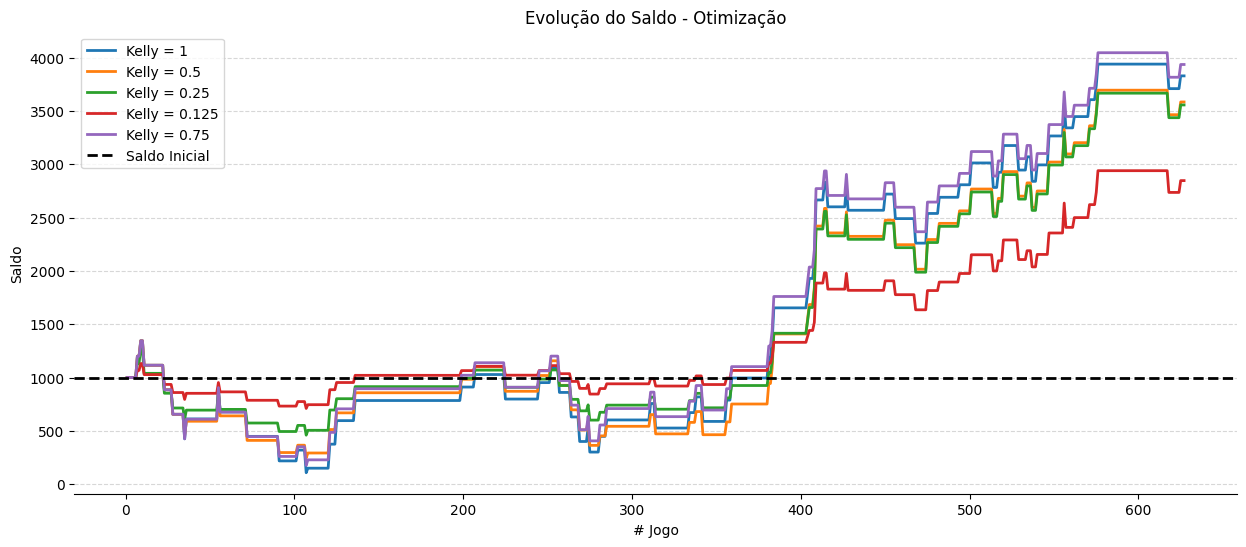

,valor_total_apostado,%_jogos_apostados,qtd_apostas,valor_aposta_maxima,%_apostas_ganhas,valor_ganho_maximo,fracao_kelly,saldo_final,%_roi,%_roi_medio,%_drawdown,%_ror
0,15650.98,11.16,70,230.0,65.71,575.00,1.000,3828.94,282.89,20.49,97.28,237.73
1,14523.16,11.16,70,230.0,65.71,575.00,0.500,3584.34,258.43,20.49,93.40,239.49
2,12136.28,11.16,70,230.0,65.71,575.00,0.250,3556.35,255.64,20.49,87.47,253.03
3,8023.54,11.16,70,230.0,65.71,368.24,0.125,2846.79,184.68,20.49,75.85,278.05
4,15573.55,11.16,70,230.0,65.71,575.00,0.750,3935.74,293.57,20.49,95.66,243.87


In [272]:
# k = 0.75
max_vlr_aposta = 230
probw_th = 0.8
probl_th = 0.3
diff_probw_th = 0.2
diff_probl_th = 0.4

kelly_fractions = [1, 0.5, 0.25, 0.125, 0.75] # Adicionado K = 0.75
dfs_resumo = []

plt.figure(figsize=(15, 6)) # Cria a figura

for k in kelly_fractions:

    bankroll = 1000    
    bankroll_history = [bankroll]
    stakes, apostas_ganhas, lucros, apostas, rois = [], [], [], [] , []

    for prob_w, odds_w, prob_l, odds_l, outcome in zip(preds_prob_w, odds_homewin, preds_prob_l, odds_awaywin, y_true):

        if prob_w >= probw_th and (prob_w - (1/odds_w)) >= diff_probw_th:            
            f_star_w = kelly_criterion_fraction(prob_w, odds_w, k) # Kelly apostando na vitoria
            f_star_w = f_star_w if f_star_w > 0 else 0
            stake_w = np.min([f_star_w*bankroll, max_vlr_aposta])
            if stake_w > 0 :
                flag_aposta = 1
            else:              
                flag_aposta = 0
            apostas.append(flag_aposta) 
            stakes.append(stake_w)           
            bankroll -= stake_w
            if outcome == 1 and stake_w > 0:
                aposta_ganha = 1
                win_value = stake_w * (odds_w - 1)
                lucros.append(win_value)
                bankroll += stake_w + win_value 
                apostas_ganhas.append(aposta_ganha)
                roi = win_value/stake_w
                rois.append(roi)
            else:            
                aposta_ganha = 0
                lucros.append(-stake_w)
                apostas_ganhas.append(aposta_ganha)
                roi = -1
                rois.append(roi)

        if prob_l >= probl_th and (prob_l - (1/odds_l)) >= diff_probl_th:            
            f_star_l = kelly_criterion_fraction(prob_l, odds_l, k) # Kelly apostando na derrota
            f_star_l = f_star_l if f_star_l > 0 else 0
            stake_l = np.min([f_star_l*bankroll, max_vlr_aposta])
            if stake_l > 0 :
                flag_aposta = 1
            else:              
                flag_aposta = 0
            apostas.append(flag_aposta)
            stakes.append(stake_l)
            bankroll -= stake_l
            if outcome == -1 and stake_l > 0:
                aposta_ganha = 1
                win_value = stake_l * (odds_l - 1)
                lucros.append(win_value)
                bankroll += stake_l + win_value 
                apostas_ganhas.append(aposta_ganha)
                roi = win_value/stake_l
                rois.append(roi)
            else:            
                aposta_ganha = 0
                lucros.append(-stake_l)
                apostas_ganhas.append(aposta_ganha)
                roi = -1
                rois.append(roi)

        bankroll = np.max([0,bankroll])       
        bankroll_history.append(bankroll)

    valor_total_apostado = np.sum(stakes) 
    max_valor_apostado = np.max(stakes)
    max_valor_ganho = np.max(lucros)
    drawdown = (np.max(bankroll_history) - np.min(bankroll_history)) / np.max(bankroll_history)
    roi_avg = np.mean(rois)
    taxa_aposta_ganha = np.sum(apostas_ganhas) / np.sum(apostas)
    desv_padrao_sld = np.std(bankroll_history)
    ganhos = np.sum(lucros)
    roi = (bankroll_history[-1]/bankroll_history[0] -1)
    ror = (bankroll_history[-1] - bankroll_history[0]) / desv_padrao_sld # Retorno sobre Risco (ROR)

    num_jogo = range(1, len(bankroll_history) + 1)
    qtd_jogos_apostados = np.sum(apostas)
    qtd_apostas_ganhas = np.sum(apostas_ganhas)



    df_k = pd.DataFrame({
                        'valor_total_apostado': [round(valor_total_apostado,2)],
                        '%_jogos_apostados': [round(qtd_jogos_apostados/len(bankroll_history)*100,2)],
                        'qtd_apostas': [round(qtd_jogos_apostados,2)],
                        'valor_aposta_maxima': [round(max_valor_apostado,2)],
                        '%_apostas_ganhas': [round(qtd_apostas_ganhas/qtd_jogos_apostados*100,2)],
                        'valor_ganho_maximo':[round(max_valor_ganho,2)],
                        'fracao_kelly': [k],
                        'saldo_final': [round(bankroll_history[-1],2)],
                        '%_roi': [round(roi*100,2)],
                        '%_roi_medio': [round(roi_avg*100,2)],
                        '%_drawdown' : [round(drawdown*100,2)],
                        '%_ror': [round(ror*100,2)]
                        })

    dfs_resumo.append(df_k)

    plt.plot(num_jogo, bankroll_history, linewidth=2, label=f'Kelly = {k}')

plt.axhline(y=bankroll_history[0], color='black', linewidth=2, linestyle='--', label='Saldo Inicial')

plt.xlabel('# Jogo')
plt.ylabel('Saldo')
plt.title('Evolução do Saldo - Otimização')
plt.legend()

sns.despine(left=True)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

plt.show()

df_comparacao_k = pd.concat(dfs_resumo, ignore_index=True)

df_comparacao_k

Resultados após otimização:
-   Todos os cenários obtiveram retorno positivo, sendo o maior deles com o K otimizado de 0.75 (ROI de 293%)
-   Nota-se ainda que o retorno foi positivo com apenas 11% dos jogos apostados, sendo que destes ~66% foram em apostas ganhas.

### Tabela Comparativa - Melhores Resultados de cada Simulação
| Simulação | Vlr. Total Apostado | % Jogos Apostados | Qtd. Apostas | Vlr. Aposta Max. | % Apostas Ganhas | Vlr. Ganho Max | K     | Sld. Final | % ROI  | % ROI Med. | % Drawdown | % ROR   |
|-----------|---------------------|-------------------|--------------|------------------|------------------|----------------|-------|------------|--------|------------|------------|---------|
| 1         | 10106.88            | 96.49             | 605          | 100.0            | 45.45            | 163.72         | 0.125 | 349.04     | -65.10 | -10.98     | 93.17      | -289.72 |
| 2         | 25386.00            | 99.84             | 626          | 100.0            | 46.01            | 280.08         | 0.125 | 1854.09   | 85.41  | 6.96      | 94.63      | 132.31 |
| 3         | 21873.53            | 99.84             | 626          | 100.0            | 61.98            | 275.78         | 0.125 | 1314.28   | 31.43  | -0.21     | 95.84      | 64.13 |
| 4 (Árvore)         | 21947.91            | 57.58             | 361          | 90.0             | 72.30            | 225.0          | 0.125 | 2288.35   | 128.83 | -3.41     | 80.95      | 195.48 |
| 5 (Otimização)        | 15573.55            | 11.16             | 70           | 230.0            | 65.71            | 575.00         | 0.750 | 3935.74   | 293.57 | 20.49     | 95.66      | <font color="green">**243.87**</font> |


Com base nos resultados apresentados, podemos concluir que a estratégia 5 (Otimização) foi a que obteve os melhores resultados. Essa estratégia teve o maior saldo final, o maior % ROI e o maior % ROR, que foi a metrica otimizada

As estratégias 2,3 e 4 também obtiveram resultados positivos, com um % ROI de 85,41%, 31,43% e 128,83%, respectivamente. No entanto, o valor total apostado são superiores (~ R$ 20k) em relação à estratégia 5. Isso indica que essas estratégias estão suscetíveis a maiores perdas, aumentando o seu risco.

A  estratégia 1 teve o pior resultado, com um % ROI de -65,10%.

Portanto, recomenda-se o uso da estratégia 5 (Otimização) para apostas futuras! 🚀

Ainda assim, é **importante ressaltar** que qualquer estratégia está sujeita a erros e que atividades de apostas podem trazer perdas financeiras.